# Training a Neural Network with PyTorch (1.0 points)

In this assignment, your task is to train a Neural Network or Multilayered Perceptron (MLP) classifier on synthetic data using PyTorch. We'll start by creating the same network architecture as in last week's assignment, only using PyTorch instead of our own implementatino. Before you start, make sure you've installed PyTorch in your conda installation: `conda install pytorch torchvision`

Please read the assignment entirely before you start coding. Most of the code that implements the neural network is provided to you. What you are expected to do is fill in certain missing parts that are required and then train 2 different networks using gradient descent (Details below). 

- <a href='#question 1'>Question 1</a>
- <a href='#question 2'>Question 2</a>
- <a href='#question 3'>Question 3</a>
- <a href='#question 4'>Question 4</a>
  
    

## Imports

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from construct_data import construct_data
from numpy.random import RandomState
from numpy import unravel_index


import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time

## Data Generation - Visualization

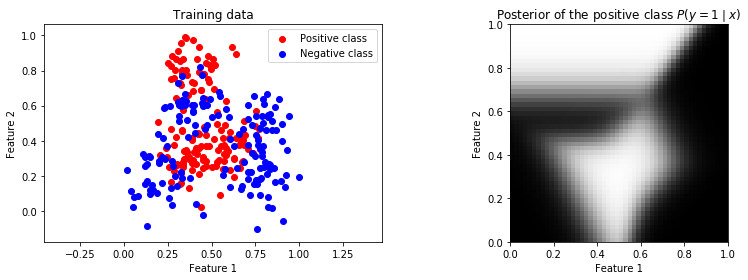

In [2]:
prng=RandomState(1)


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

training_features, training_labels, posterior = construct_data(300, 'train', 'nonlinear' , plusminus=False)

# Extract features for both classes
features_pos = training_features[training_labels == 1]
features_neg = training_features[training_labels != 1]

# Display data
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(features_pos[:, 0], features_pos[:, 1], c="red", label="Positive class")
ax.scatter(features_neg[:, 0], features_neg[:, 1], c="blue", label="Negative class")
ax.axis('equal')
ax.set_title("Training data")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.imshow(posterior, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Posterior of the positive class $P(y=1 \mid x)$")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
plt.show()



## Generate test set 

In [3]:
test_features, test_labels, _ = construct_data(100, 'test', 'nonlinear' , plusminus=False)


##  Convert data to Torch tensors

All computations in torch are performed on tensors ( generalizations of a matrix that can be indexed in more than 2 dimensions). Therefore we need to first convert our testing and training data to tensors.

In [4]:

training_features_tensor = torch.FloatTensor(training_features)
training_labels_tensor = torch.FloatTensor(training_labels)
test_features_tensor = torch.FloatTensor(test_features)
test_labels_tensor = torch.FloatTensor(test_labels)


Next we'll use the training label and feature tensors to create a TensorDataset as well as a DataLoader that allows us to load batches of our data during each training iteration.

In [5]:
# loader for training set 
batch_size = 40
trainset = torch.utils.data.TensorDataset(training_features_tensor, training_labels_tensor)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)


## Simple Network in PyTorch

The following cell, demonstrates how to create a very simple network with only one hidded layer with 3 nodes. In the constructor function `__init__()` we create the layers and within function `forward()` we define the structure of the network.

In [6]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 3)
        self.fc2 = nn.Linear(3, 2)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        return x

<a id='question 1'></a>
## Train a network with sigmoid non-linearities across all layers

In this assignment we'll create the same neural network we created last week, with [2,10,10,2] nodes (i.e. 2 inputs, 2 layers with 10 nodes and 2 outputs). We'll use sigmoid activations for the hidden layers.  
* Question 1: Use the previous simple network as a guide in order to create the network described. Add the necessary lines inside `__init__` and `forward`.


In [7]:
class SigmoidNet(nn.Module):
    def __init__(self):
        super().__init__()
        ###### TODO QUESTION 1 ########
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 2)
        ###### TODO QUESTION 1 ########
    def forward(self, x):
        ###### TODO QUESTION 1 ########
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        
        ###### TODO QUESTION 1 ########
        return x



In [8]:
#Next we'll create an instance of our SigmoidNet class
sigmoid_net = SigmoidNet()

In [9]:
# Here we define the learning rate and the number of epochs for our training. 
#Hint: start with a small number of epochs (around 500) to check if everything 
# is working and only then run it for 8000 epochs)
learning_rate=0.05 # 
epochs = 4000  ## usually has already converged around that number

## Here we pick the cost function and the optimizer for our training
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(sigmoid_net.parameters(), lr=learning_rate, momentum=0.9)

## Training SigmoidNet
In the next cell the actual training happens. The network is trained for many epochs and for each of the epochs we split our training data into mini batches using the DataLoader that we created previously and iteratively feed them into our network. After each iteration/optimizer step, the parameters are updated in such a way that the loss is minimized.

In [11]:
start = time.time()

sigmoid_costs=[]  
sigmoid_accuracies = []

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    num_of_batches = 0 
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        logits = sigmoid_net(inputs)
        loss = criterion(logits, labels.type(torch.LongTensor))
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        num_of_batches +=1
        
    # calculate test accuracy 
    test_logits = sigmoid_net(Variable(test_features_tensor))
    _, test_predictions = torch.max(test_logits.data, 1)    
    correct_predictions = (test_predictions.int() == test_labels_tensor.int()).sum()
    test_length = test_labels_tensor.size()[0]
    accuracy = correct_predictions/test_length
    print('Epoch: %d/%d,  loss: %.3f, test accuracy: %.3f'%(epoch + 1,epochs, running_loss / num_of_batches, accuracy))
    sigmoid_costs.append(running_loss/num_of_batches)
    sigmoid_accuracies.append(accuracy)

    

end = time.time()
duration = end-start
print('Finished Training in %d seconds'%(end-start))

Epoch: 1/4000,  loss: 0.625, test accuracy: 0.650
Epoch: 2/4000,  loss: 0.618, test accuracy: 0.650
Epoch: 3/4000,  loss: 0.613, test accuracy: 0.630
Epoch: 4/4000,  loss: 0.620, test accuracy: 0.650
Epoch: 5/4000,  loss: 0.617, test accuracy: 0.640
Epoch: 6/4000,  loss: 0.623, test accuracy: 0.640
Epoch: 7/4000,  loss: 0.625, test accuracy: 0.650
Epoch: 8/4000,  loss: 0.616, test accuracy: 0.630
Epoch: 9/4000,  loss: 0.629, test accuracy: 0.650
Epoch: 10/4000,  loss: 0.618, test accuracy: 0.630
Epoch: 11/4000,  loss: 0.616, test accuracy: 0.640
Epoch: 12/4000,  loss: 0.622, test accuracy: 0.650
Epoch: 13/4000,  loss: 0.624, test accuracy: 0.660
Epoch: 14/4000,  loss: 0.625, test accuracy: 0.650
Epoch: 15/4000,  loss: 0.614, test accuracy: 0.650
Epoch: 16/4000,  loss: 0.630, test accuracy: 0.660
Epoch: 17/4000,  loss: 0.625, test accuracy: 0.620
Epoch: 18/4000,  loss: 0.619, test accuracy: 0.650
Epoch: 19/4000,  loss: 0.619, test accuracy: 0.650
Epoch: 20/4000,  loss: 0.620, test accur

Epoch: 160/4000,  loss: 0.509, test accuracy: 0.820
Epoch: 161/4000,  loss: 0.495, test accuracy: 0.800
Epoch: 162/4000,  loss: 0.502, test accuracy: 0.810
Epoch: 163/4000,  loss: 0.511, test accuracy: 0.820
Epoch: 164/4000,  loss: 0.505, test accuracy: 0.800
Epoch: 165/4000,  loss: 0.501, test accuracy: 0.810
Epoch: 166/4000,  loss: 0.511, test accuracy: 0.820
Epoch: 167/4000,  loss: 0.502, test accuracy: 0.820
Epoch: 168/4000,  loss: 0.512, test accuracy: 0.810
Epoch: 169/4000,  loss: 0.494, test accuracy: 0.800
Epoch: 170/4000,  loss: 0.501, test accuracy: 0.820
Epoch: 171/4000,  loss: 0.499, test accuracy: 0.820
Epoch: 172/4000,  loss: 0.517, test accuracy: 0.810
Epoch: 173/4000,  loss: 0.525, test accuracy: 0.800
Epoch: 174/4000,  loss: 0.508, test accuracy: 0.790
Epoch: 175/4000,  loss: 0.504, test accuracy: 0.810
Epoch: 176/4000,  loss: 0.503, test accuracy: 0.810
Epoch: 177/4000,  loss: 0.505, test accuracy: 0.810
Epoch: 178/4000,  loss: 0.498, test accuracy: 0.810
Epoch: 179/4

Epoch: 318/4000,  loss: 0.483, test accuracy: 0.820
Epoch: 319/4000,  loss: 0.489, test accuracy: 0.830
Epoch: 320/4000,  loss: 0.487, test accuracy: 0.820
Epoch: 321/4000,  loss: 0.487, test accuracy: 0.820
Epoch: 322/4000,  loss: 0.484, test accuracy: 0.830
Epoch: 323/4000,  loss: 0.484, test accuracy: 0.820
Epoch: 324/4000,  loss: 0.488, test accuracy: 0.820
Epoch: 325/4000,  loss: 0.484, test accuracy: 0.810
Epoch: 326/4000,  loss: 0.475, test accuracy: 0.820
Epoch: 327/4000,  loss: 0.480, test accuracy: 0.820
Epoch: 328/4000,  loss: 0.477, test accuracy: 0.820
Epoch: 329/4000,  loss: 0.478, test accuracy: 0.810
Epoch: 330/4000,  loss: 0.494, test accuracy: 0.820
Epoch: 331/4000,  loss: 0.489, test accuracy: 0.820
Epoch: 332/4000,  loss: 0.477, test accuracy: 0.820
Epoch: 333/4000,  loss: 0.480, test accuracy: 0.830
Epoch: 334/4000,  loss: 0.492, test accuracy: 0.820
Epoch: 335/4000,  loss: 0.486, test accuracy: 0.820
Epoch: 336/4000,  loss: 0.490, test accuracy: 0.810
Epoch: 337/4

Epoch: 476/4000,  loss: 0.490, test accuracy: 0.820
Epoch: 477/4000,  loss: 0.483, test accuracy: 0.810
Epoch: 478/4000,  loss: 0.483, test accuracy: 0.820
Epoch: 479/4000,  loss: 0.475, test accuracy: 0.820
Epoch: 480/4000,  loss: 0.473, test accuracy: 0.810
Epoch: 481/4000,  loss: 0.477, test accuracy: 0.820
Epoch: 482/4000,  loss: 0.486, test accuracy: 0.820
Epoch: 483/4000,  loss: 0.491, test accuracy: 0.810
Epoch: 484/4000,  loss: 0.477, test accuracy: 0.810
Epoch: 485/4000,  loss: 0.477, test accuracy: 0.820
Epoch: 486/4000,  loss: 0.477, test accuracy: 0.820
Epoch: 487/4000,  loss: 0.496, test accuracy: 0.810
Epoch: 488/4000,  loss: 0.478, test accuracy: 0.820
Epoch: 489/4000,  loss: 0.480, test accuracy: 0.820
Epoch: 490/4000,  loss: 0.484, test accuracy: 0.800
Epoch: 491/4000,  loss: 0.479, test accuracy: 0.830
Epoch: 492/4000,  loss: 0.486, test accuracy: 0.810
Epoch: 493/4000,  loss: 0.471, test accuracy: 0.810
Epoch: 494/4000,  loss: 0.485, test accuracy: 0.820
Epoch: 495/4

Epoch: 634/4000,  loss: 0.479, test accuracy: 0.820
Epoch: 635/4000,  loss: 0.473, test accuracy: 0.810
Epoch: 636/4000,  loss: 0.473, test accuracy: 0.810
Epoch: 637/4000,  loss: 0.469, test accuracy: 0.820
Epoch: 638/4000,  loss: 0.485, test accuracy: 0.820
Epoch: 639/4000,  loss: 0.483, test accuracy: 0.820
Epoch: 640/4000,  loss: 0.482, test accuracy: 0.820
Epoch: 641/4000,  loss: 0.480, test accuracy: 0.800
Epoch: 642/4000,  loss: 0.473, test accuracy: 0.820
Epoch: 643/4000,  loss: 0.476, test accuracy: 0.810
Epoch: 644/4000,  loss: 0.491, test accuracy: 0.800
Epoch: 645/4000,  loss: 0.471, test accuracy: 0.810
Epoch: 646/4000,  loss: 0.470, test accuracy: 0.810
Epoch: 647/4000,  loss: 0.470, test accuracy: 0.810
Epoch: 648/4000,  loss: 0.478, test accuracy: 0.820
Epoch: 649/4000,  loss: 0.479, test accuracy: 0.810
Epoch: 650/4000,  loss: 0.485, test accuracy: 0.820
Epoch: 651/4000,  loss: 0.487, test accuracy: 0.820
Epoch: 652/4000,  loss: 0.480, test accuracy: 0.820
Epoch: 653/4

Epoch: 792/4000,  loss: 0.473, test accuracy: 0.800
Epoch: 793/4000,  loss: 0.472, test accuracy: 0.810
Epoch: 794/4000,  loss: 0.481, test accuracy: 0.820
Epoch: 795/4000,  loss: 0.480, test accuracy: 0.810
Epoch: 796/4000,  loss: 0.474, test accuracy: 0.810
Epoch: 797/4000,  loss: 0.486, test accuracy: 0.810
Epoch: 798/4000,  loss: 0.472, test accuracy: 0.820
Epoch: 799/4000,  loss: 0.472, test accuracy: 0.810
Epoch: 800/4000,  loss: 0.469, test accuracy: 0.800
Epoch: 801/4000,  loss: 0.481, test accuracy: 0.800
Epoch: 802/4000,  loss: 0.479, test accuracy: 0.820
Epoch: 803/4000,  loss: 0.476, test accuracy: 0.820
Epoch: 804/4000,  loss: 0.480, test accuracy: 0.810
Epoch: 805/4000,  loss: 0.463, test accuracy: 0.810
Epoch: 806/4000,  loss: 0.480, test accuracy: 0.800
Epoch: 807/4000,  loss: 0.479, test accuracy: 0.820
Epoch: 808/4000,  loss: 0.476, test accuracy: 0.820
Epoch: 809/4000,  loss: 0.472, test accuracy: 0.810
Epoch: 810/4000,  loss: 0.462, test accuracy: 0.800
Epoch: 811/4

Epoch: 950/4000,  loss: 0.485, test accuracy: 0.810
Epoch: 951/4000,  loss: 0.481, test accuracy: 0.810
Epoch: 952/4000,  loss: 0.473, test accuracy: 0.820
Epoch: 953/4000,  loss: 0.474, test accuracy: 0.810
Epoch: 954/4000,  loss: 0.468, test accuracy: 0.820
Epoch: 955/4000,  loss: 0.468, test accuracy: 0.810
Epoch: 956/4000,  loss: 0.483, test accuracy: 0.810
Epoch: 957/4000,  loss: 0.492, test accuracy: 0.820
Epoch: 958/4000,  loss: 0.478, test accuracy: 0.800
Epoch: 959/4000,  loss: 0.462, test accuracy: 0.800
Epoch: 960/4000,  loss: 0.473, test accuracy: 0.820
Epoch: 961/4000,  loss: 0.476, test accuracy: 0.810
Epoch: 962/4000,  loss: 0.465, test accuracy: 0.810
Epoch: 963/4000,  loss: 0.476, test accuracy: 0.810
Epoch: 964/4000,  loss: 0.476, test accuracy: 0.800
Epoch: 965/4000,  loss: 0.468, test accuracy: 0.800
Epoch: 966/4000,  loss: 0.473, test accuracy: 0.820
Epoch: 967/4000,  loss: 0.470, test accuracy: 0.810
Epoch: 968/4000,  loss: 0.467, test accuracy: 0.820
Epoch: 969/4

Epoch: 1106/4000,  loss: 0.470, test accuracy: 0.820
Epoch: 1107/4000,  loss: 0.470, test accuracy: 0.810
Epoch: 1108/4000,  loss: 0.465, test accuracy: 0.810
Epoch: 1109/4000,  loss: 0.470, test accuracy: 0.820
Epoch: 1110/4000,  loss: 0.476, test accuracy: 0.800
Epoch: 1111/4000,  loss: 0.467, test accuracy: 0.810
Epoch: 1112/4000,  loss: 0.478, test accuracy: 0.800
Epoch: 1113/4000,  loss: 0.473, test accuracy: 0.800
Epoch: 1114/4000,  loss: 0.474, test accuracy: 0.810
Epoch: 1115/4000,  loss: 0.465, test accuracy: 0.800
Epoch: 1116/4000,  loss: 0.459, test accuracy: 0.810
Epoch: 1117/4000,  loss: 0.473, test accuracy: 0.810
Epoch: 1118/4000,  loss: 0.477, test accuracy: 0.820
Epoch: 1119/4000,  loss: 0.486, test accuracy: 0.810
Epoch: 1120/4000,  loss: 0.466, test accuracy: 0.810
Epoch: 1121/4000,  loss: 0.484, test accuracy: 0.800
Epoch: 1122/4000,  loss: 0.476, test accuracy: 0.810
Epoch: 1123/4000,  loss: 0.464, test accuracy: 0.810
Epoch: 1124/4000,  loss: 0.466, test accuracy:

Epoch: 1261/4000,  loss: 0.474, test accuracy: 0.810
Epoch: 1262/4000,  loss: 0.479, test accuracy: 0.810
Epoch: 1263/4000,  loss: 0.480, test accuracy: 0.820
Epoch: 1264/4000,  loss: 0.480, test accuracy: 0.810
Epoch: 1265/4000,  loss: 0.474, test accuracy: 0.800
Epoch: 1266/4000,  loss: 0.471, test accuracy: 0.820
Epoch: 1267/4000,  loss: 0.466, test accuracy: 0.800
Epoch: 1268/4000,  loss: 0.484, test accuracy: 0.810
Epoch: 1269/4000,  loss: 0.484, test accuracy: 0.810
Epoch: 1270/4000,  loss: 0.478, test accuracy: 0.810
Epoch: 1271/4000,  loss: 0.484, test accuracy: 0.800
Epoch: 1272/4000,  loss: 0.484, test accuracy: 0.810
Epoch: 1273/4000,  loss: 0.473, test accuracy: 0.810
Epoch: 1274/4000,  loss: 0.480, test accuracy: 0.800
Epoch: 1275/4000,  loss: 0.471, test accuracy: 0.810
Epoch: 1276/4000,  loss: 0.468, test accuracy: 0.800
Epoch: 1277/4000,  loss: 0.482, test accuracy: 0.820
Epoch: 1278/4000,  loss: 0.479, test accuracy: 0.820
Epoch: 1279/4000,  loss: 0.465, test accuracy:

Epoch: 1416/4000,  loss: 0.465, test accuracy: 0.800
Epoch: 1417/4000,  loss: 0.481, test accuracy: 0.800
Epoch: 1418/4000,  loss: 0.466, test accuracy: 0.810
Epoch: 1419/4000,  loss: 0.469, test accuracy: 0.810
Epoch: 1420/4000,  loss: 0.470, test accuracy: 0.810
Epoch: 1421/4000,  loss: 0.477, test accuracy: 0.810
Epoch: 1422/4000,  loss: 0.480, test accuracy: 0.800
Epoch: 1423/4000,  loss: 0.477, test accuracy: 0.800
Epoch: 1424/4000,  loss: 0.467, test accuracy: 0.820
Epoch: 1425/4000,  loss: 0.476, test accuracy: 0.800
Epoch: 1426/4000,  loss: 0.474, test accuracy: 0.810
Epoch: 1427/4000,  loss: 0.474, test accuracy: 0.800
Epoch: 1428/4000,  loss: 0.465, test accuracy: 0.810
Epoch: 1429/4000,  loss: 0.487, test accuracy: 0.800
Epoch: 1430/4000,  loss: 0.468, test accuracy: 0.820
Epoch: 1431/4000,  loss: 0.467, test accuracy: 0.800
Epoch: 1432/4000,  loss: 0.473, test accuracy: 0.800
Epoch: 1433/4000,  loss: 0.479, test accuracy: 0.820
Epoch: 1434/4000,  loss: 0.473, test accuracy:

Epoch: 1571/4000,  loss: 0.473, test accuracy: 0.810
Epoch: 1572/4000,  loss: 0.466, test accuracy: 0.800
Epoch: 1573/4000,  loss: 0.472, test accuracy: 0.800
Epoch: 1574/4000,  loss: 0.468, test accuracy: 0.800
Epoch: 1575/4000,  loss: 0.466, test accuracy: 0.800
Epoch: 1576/4000,  loss: 0.466, test accuracy: 0.800
Epoch: 1577/4000,  loss: 0.477, test accuracy: 0.810
Epoch: 1578/4000,  loss: 0.469, test accuracy: 0.800
Epoch: 1579/4000,  loss: 0.470, test accuracy: 0.800
Epoch: 1580/4000,  loss: 0.464, test accuracy: 0.800
Epoch: 1581/4000,  loss: 0.484, test accuracy: 0.810
Epoch: 1582/4000,  loss: 0.468, test accuracy: 0.810
Epoch: 1583/4000,  loss: 0.477, test accuracy: 0.800
Epoch: 1584/4000,  loss: 0.473, test accuracy: 0.800
Epoch: 1585/4000,  loss: 0.463, test accuracy: 0.800
Epoch: 1586/4000,  loss: 0.472, test accuracy: 0.800
Epoch: 1587/4000,  loss: 0.468, test accuracy: 0.800
Epoch: 1588/4000,  loss: 0.465, test accuracy: 0.800
Epoch: 1589/4000,  loss: 0.472, test accuracy:

Epoch: 1726/4000,  loss: 0.465, test accuracy: 0.800
Epoch: 1727/4000,  loss: 0.461, test accuracy: 0.800
Epoch: 1728/4000,  loss: 0.471, test accuracy: 0.800
Epoch: 1729/4000,  loss: 0.500, test accuracy: 0.810
Epoch: 1730/4000,  loss: 0.473, test accuracy: 0.820
Epoch: 1731/4000,  loss: 0.480, test accuracy: 0.800
Epoch: 1732/4000,  loss: 0.466, test accuracy: 0.820
Epoch: 1733/4000,  loss: 0.473, test accuracy: 0.820
Epoch: 1734/4000,  loss: 0.467, test accuracy: 0.820
Epoch: 1735/4000,  loss: 0.475, test accuracy: 0.810
Epoch: 1736/4000,  loss: 0.477, test accuracy: 0.820
Epoch: 1737/4000,  loss: 0.464, test accuracy: 0.810
Epoch: 1738/4000,  loss: 0.466, test accuracy: 0.800
Epoch: 1739/4000,  loss: 0.470, test accuracy: 0.800
Epoch: 1740/4000,  loss: 0.497, test accuracy: 0.810
Epoch: 1741/4000,  loss: 0.489, test accuracy: 0.780
Epoch: 1742/4000,  loss: 0.476, test accuracy: 0.820
Epoch: 1743/4000,  loss: 0.481, test accuracy: 0.810
Epoch: 1744/4000,  loss: 0.483, test accuracy:

Epoch: 1881/4000,  loss: 0.478, test accuracy: 0.810
Epoch: 1882/4000,  loss: 0.475, test accuracy: 0.820
Epoch: 1883/4000,  loss: 0.469, test accuracy: 0.810
Epoch: 1884/4000,  loss: 0.480, test accuracy: 0.810
Epoch: 1885/4000,  loss: 0.458, test accuracy: 0.810
Epoch: 1886/4000,  loss: 0.468, test accuracy: 0.810
Epoch: 1887/4000,  loss: 0.495, test accuracy: 0.810
Epoch: 1888/4000,  loss: 0.460, test accuracy: 0.810
Epoch: 1889/4000,  loss: 0.465, test accuracy: 0.810
Epoch: 1890/4000,  loss: 0.461, test accuracy: 0.810
Epoch: 1891/4000,  loss: 0.471, test accuracy: 0.800
Epoch: 1892/4000,  loss: 0.475, test accuracy: 0.800
Epoch: 1893/4000,  loss: 0.477, test accuracy: 0.800
Epoch: 1894/4000,  loss: 0.473, test accuracy: 0.810
Epoch: 1895/4000,  loss: 0.473, test accuracy: 0.790
Epoch: 1896/4000,  loss: 0.462, test accuracy: 0.800
Epoch: 1897/4000,  loss: 0.473, test accuracy: 0.810
Epoch: 1898/4000,  loss: 0.472, test accuracy: 0.800
Epoch: 1899/4000,  loss: 0.468, test accuracy:

Epoch: 2036/4000,  loss: 0.468, test accuracy: 0.800
Epoch: 2037/4000,  loss: 0.494, test accuracy: 0.820
Epoch: 2038/4000,  loss: 0.460, test accuracy: 0.810
Epoch: 2039/4000,  loss: 0.470, test accuracy: 0.800
Epoch: 2040/4000,  loss: 0.467, test accuracy: 0.800
Epoch: 2041/4000,  loss: 0.473, test accuracy: 0.810
Epoch: 2042/4000,  loss: 0.476, test accuracy: 0.800
Epoch: 2043/4000,  loss: 0.472, test accuracy: 0.800
Epoch: 2044/4000,  loss: 0.468, test accuracy: 0.810
Epoch: 2045/4000,  loss: 0.472, test accuracy: 0.810
Epoch: 2046/4000,  loss: 0.468, test accuracy: 0.800
Epoch: 2047/4000,  loss: 0.474, test accuracy: 0.810
Epoch: 2048/4000,  loss: 0.465, test accuracy: 0.810
Epoch: 2049/4000,  loss: 0.471, test accuracy: 0.800
Epoch: 2050/4000,  loss: 0.466, test accuracy: 0.810
Epoch: 2051/4000,  loss: 0.485, test accuracy: 0.810
Epoch: 2052/4000,  loss: 0.465, test accuracy: 0.820
Epoch: 2053/4000,  loss: 0.468, test accuracy: 0.820
Epoch: 2054/4000,  loss: 0.476, test accuracy:

Epoch: 2191/4000,  loss: 0.467, test accuracy: 0.820
Epoch: 2192/4000,  loss: 0.476, test accuracy: 0.810
Epoch: 2193/4000,  loss: 0.479, test accuracy: 0.810
Epoch: 2194/4000,  loss: 0.473, test accuracy: 0.820
Epoch: 2195/4000,  loss: 0.468, test accuracy: 0.820
Epoch: 2196/4000,  loss: 0.472, test accuracy: 0.820
Epoch: 2197/4000,  loss: 0.480, test accuracy: 0.810
Epoch: 2198/4000,  loss: 0.462, test accuracy: 0.810
Epoch: 2199/4000,  loss: 0.472, test accuracy: 0.820
Epoch: 2200/4000,  loss: 0.463, test accuracy: 0.810
Epoch: 2201/4000,  loss: 0.468, test accuracy: 0.820
Epoch: 2202/4000,  loss: 0.466, test accuracy: 0.810
Epoch: 2203/4000,  loss: 0.463, test accuracy: 0.820
Epoch: 2204/4000,  loss: 0.473, test accuracy: 0.810
Epoch: 2205/4000,  loss: 0.489, test accuracy: 0.810
Epoch: 2206/4000,  loss: 0.466, test accuracy: 0.810
Epoch: 2207/4000,  loss: 0.477, test accuracy: 0.820
Epoch: 2208/4000,  loss: 0.473, test accuracy: 0.810
Epoch: 2209/4000,  loss: 0.468, test accuracy:

Epoch: 2346/4000,  loss: 0.456, test accuracy: 0.820
Epoch: 2347/4000,  loss: 0.465, test accuracy: 0.800
Epoch: 2348/4000,  loss: 0.476, test accuracy: 0.810
Epoch: 2349/4000,  loss: 0.476, test accuracy: 0.810
Epoch: 2350/4000,  loss: 0.479, test accuracy: 0.820
Epoch: 2351/4000,  loss: 0.467, test accuracy: 0.800
Epoch: 2352/4000,  loss: 0.466, test accuracy: 0.810
Epoch: 2353/4000,  loss: 0.472, test accuracy: 0.810
Epoch: 2354/4000,  loss: 0.473, test accuracy: 0.810
Epoch: 2355/4000,  loss: 0.467, test accuracy: 0.820
Epoch: 2356/4000,  loss: 0.475, test accuracy: 0.820
Epoch: 2357/4000,  loss: 0.468, test accuracy: 0.810
Epoch: 2358/4000,  loss: 0.481, test accuracy: 0.810
Epoch: 2359/4000,  loss: 0.474, test accuracy: 0.820
Epoch: 2360/4000,  loss: 0.460, test accuracy: 0.810
Epoch: 2361/4000,  loss: 0.474, test accuracy: 0.820
Epoch: 2362/4000,  loss: 0.462, test accuracy: 0.810
Epoch: 2363/4000,  loss: 0.472, test accuracy: 0.810
Epoch: 2364/4000,  loss: 0.476, test accuracy:

Epoch: 2501/4000,  loss: 0.472, test accuracy: 0.810
Epoch: 2502/4000,  loss: 0.480, test accuracy: 0.820
Epoch: 2503/4000,  loss: 0.466, test accuracy: 0.810
Epoch: 2504/4000,  loss: 0.474, test accuracy: 0.820
Epoch: 2505/4000,  loss: 0.464, test accuracy: 0.810
Epoch: 2506/4000,  loss: 0.470, test accuracy: 0.810
Epoch: 2507/4000,  loss: 0.470, test accuracy: 0.820
Epoch: 2508/4000,  loss: 0.469, test accuracy: 0.820
Epoch: 2509/4000,  loss: 0.463, test accuracy: 0.820
Epoch: 2510/4000,  loss: 0.472, test accuracy: 0.820
Epoch: 2511/4000,  loss: 0.461, test accuracy: 0.810
Epoch: 2512/4000,  loss: 0.468, test accuracy: 0.800
Epoch: 2513/4000,  loss: 0.459, test accuracy: 0.820
Epoch: 2514/4000,  loss: 0.464, test accuracy: 0.820
Epoch: 2515/4000,  loss: 0.465, test accuracy: 0.810
Epoch: 2516/4000,  loss: 0.479, test accuracy: 0.810
Epoch: 2517/4000,  loss: 0.467, test accuracy: 0.820
Epoch: 2518/4000,  loss: 0.471, test accuracy: 0.810
Epoch: 2519/4000,  loss: 0.479, test accuracy:

Epoch: 2656/4000,  loss: 0.468, test accuracy: 0.810
Epoch: 2657/4000,  loss: 0.465, test accuracy: 0.820
Epoch: 2658/4000,  loss: 0.469, test accuracy: 0.810
Epoch: 2659/4000,  loss: 0.468, test accuracy: 0.810
Epoch: 2660/4000,  loss: 0.480, test accuracy: 0.820
Epoch: 2661/4000,  loss: 0.465, test accuracy: 0.810
Epoch: 2662/4000,  loss: 0.461, test accuracy: 0.810
Epoch: 2663/4000,  loss: 0.463, test accuracy: 0.810
Epoch: 2664/4000,  loss: 0.468, test accuracy: 0.810
Epoch: 2665/4000,  loss: 0.467, test accuracy: 0.810
Epoch: 2666/4000,  loss: 0.462, test accuracy: 0.820
Epoch: 2667/4000,  loss: 0.464, test accuracy: 0.820
Epoch: 2668/4000,  loss: 0.473, test accuracy: 0.810
Epoch: 2669/4000,  loss: 0.462, test accuracy: 0.820
Epoch: 2670/4000,  loss: 0.479, test accuracy: 0.810
Epoch: 2671/4000,  loss: 0.472, test accuracy: 0.810
Epoch: 2672/4000,  loss: 0.483, test accuracy: 0.810
Epoch: 2673/4000,  loss: 0.475, test accuracy: 0.820
Epoch: 2674/4000,  loss: 0.473, test accuracy:

Epoch: 2811/4000,  loss: 0.476, test accuracy: 0.820
Epoch: 2812/4000,  loss: 0.468, test accuracy: 0.810
Epoch: 2813/4000,  loss: 0.467, test accuracy: 0.810
Epoch: 2814/4000,  loss: 0.476, test accuracy: 0.800
Epoch: 2815/4000,  loss: 0.463, test accuracy: 0.820
Epoch: 2816/4000,  loss: 0.478, test accuracy: 0.810
Epoch: 2817/4000,  loss: 0.473, test accuracy: 0.810
Epoch: 2818/4000,  loss: 0.477, test accuracy: 0.790
Epoch: 2819/4000,  loss: 0.480, test accuracy: 0.820
Epoch: 2820/4000,  loss: 0.466, test accuracy: 0.810
Epoch: 2821/4000,  loss: 0.465, test accuracy: 0.810
Epoch: 2822/4000,  loss: 0.467, test accuracy: 0.810
Epoch: 2823/4000,  loss: 0.467, test accuracy: 0.810
Epoch: 2824/4000,  loss: 0.463, test accuracy: 0.810
Epoch: 2825/4000,  loss: 0.463, test accuracy: 0.820
Epoch: 2826/4000,  loss: 0.471, test accuracy: 0.810
Epoch: 2827/4000,  loss: 0.469, test accuracy: 0.810
Epoch: 2828/4000,  loss: 0.458, test accuracy: 0.820
Epoch: 2829/4000,  loss: 0.469, test accuracy:

Epoch: 2965/4000,  loss: 0.470, test accuracy: 0.810
Epoch: 2966/4000,  loss: 0.467, test accuracy: 0.820
Epoch: 2967/4000,  loss: 0.468, test accuracy: 0.820
Epoch: 2968/4000,  loss: 0.471, test accuracy: 0.810
Epoch: 2969/4000,  loss: 0.469, test accuracy: 0.810
Epoch: 2970/4000,  loss: 0.467, test accuracy: 0.810
Epoch: 2971/4000,  loss: 0.470, test accuracy: 0.810
Epoch: 2972/4000,  loss: 0.470, test accuracy: 0.810
Epoch: 2973/4000,  loss: 0.461, test accuracy: 0.810
Epoch: 2974/4000,  loss: 0.471, test accuracy: 0.810
Epoch: 2975/4000,  loss: 0.462, test accuracy: 0.820
Epoch: 2976/4000,  loss: 0.469, test accuracy: 0.810
Epoch: 2977/4000,  loss: 0.462, test accuracy: 0.810
Epoch: 2978/4000,  loss: 0.469, test accuracy: 0.810
Epoch: 2979/4000,  loss: 0.475, test accuracy: 0.820
Epoch: 2980/4000,  loss: 0.477, test accuracy: 0.810
Epoch: 2981/4000,  loss: 0.458, test accuracy: 0.810
Epoch: 2982/4000,  loss: 0.469, test accuracy: 0.810
Epoch: 2983/4000,  loss: 0.463, test accuracy:

Epoch: 3120/4000,  loss: 0.467, test accuracy: 0.820
Epoch: 3121/4000,  loss: 0.463, test accuracy: 0.810
Epoch: 3122/4000,  loss: 0.457, test accuracy: 0.810
Epoch: 3123/4000,  loss: 0.475, test accuracy: 0.810
Epoch: 3124/4000,  loss: 0.466, test accuracy: 0.810
Epoch: 3125/4000,  loss: 0.476, test accuracy: 0.820
Epoch: 3126/4000,  loss: 0.457, test accuracy: 0.810
Epoch: 3127/4000,  loss: 0.460, test accuracy: 0.810
Epoch: 3128/4000,  loss: 0.473, test accuracy: 0.810
Epoch: 3129/4000,  loss: 0.476, test accuracy: 0.810
Epoch: 3130/4000,  loss: 0.475, test accuracy: 0.810
Epoch: 3131/4000,  loss: 0.457, test accuracy: 0.820
Epoch: 3132/4000,  loss: 0.457, test accuracy: 0.810
Epoch: 3133/4000,  loss: 0.460, test accuracy: 0.810
Epoch: 3134/4000,  loss: 0.464, test accuracy: 0.820
Epoch: 3135/4000,  loss: 0.468, test accuracy: 0.830
Epoch: 3136/4000,  loss: 0.479, test accuracy: 0.810
Epoch: 3137/4000,  loss: 0.458, test accuracy: 0.810
Epoch: 3138/4000,  loss: 0.469, test accuracy:

Epoch: 3275/4000,  loss: 0.472, test accuracy: 0.800
Epoch: 3276/4000,  loss: 0.472, test accuracy: 0.810
Epoch: 3277/4000,  loss: 0.461, test accuracy: 0.820
Epoch: 3278/4000,  loss: 0.473, test accuracy: 0.810
Epoch: 3279/4000,  loss: 0.474, test accuracy: 0.800
Epoch: 3280/4000,  loss: 0.466, test accuracy: 0.830
Epoch: 3281/4000,  loss: 0.464, test accuracy: 0.820
Epoch: 3282/4000,  loss: 0.462, test accuracy: 0.800
Epoch: 3283/4000,  loss: 0.461, test accuracy: 0.820
Epoch: 3284/4000,  loss: 0.462, test accuracy: 0.820
Epoch: 3285/4000,  loss: 0.472, test accuracy: 0.820
Epoch: 3286/4000,  loss: 0.465, test accuracy: 0.820
Epoch: 3287/4000,  loss: 0.460, test accuracy: 0.820
Epoch: 3288/4000,  loss: 0.465, test accuracy: 0.810
Epoch: 3289/4000,  loss: 0.461, test accuracy: 0.810
Epoch: 3290/4000,  loss: 0.471, test accuracy: 0.810
Epoch: 3291/4000,  loss: 0.470, test accuracy: 0.820
Epoch: 3292/4000,  loss: 0.468, test accuracy: 0.830
Epoch: 3293/4000,  loss: 0.474, test accuracy:

Epoch: 3430/4000,  loss: 0.486, test accuracy: 0.810
Epoch: 3431/4000,  loss: 0.464, test accuracy: 0.820
Epoch: 3432/4000,  loss: 0.458, test accuracy: 0.830
Epoch: 3433/4000,  loss: 0.463, test accuracy: 0.820
Epoch: 3434/4000,  loss: 0.457, test accuracy: 0.830
Epoch: 3435/4000,  loss: 0.460, test accuracy: 0.820
Epoch: 3436/4000,  loss: 0.463, test accuracy: 0.820
Epoch: 3437/4000,  loss: 0.459, test accuracy: 0.830
Epoch: 3438/4000,  loss: 0.461, test accuracy: 0.830
Epoch: 3439/4000,  loss: 0.461, test accuracy: 0.830
Epoch: 3440/4000,  loss: 0.471, test accuracy: 0.830
Epoch: 3441/4000,  loss: 0.465, test accuracy: 0.820
Epoch: 3442/4000,  loss: 0.469, test accuracy: 0.830
Epoch: 3443/4000,  loss: 0.453, test accuracy: 0.830
Epoch: 3444/4000,  loss: 0.457, test accuracy: 0.830
Epoch: 3445/4000,  loss: 0.458, test accuracy: 0.820
Epoch: 3446/4000,  loss: 0.453, test accuracy: 0.830
Epoch: 3447/4000,  loss: 0.464, test accuracy: 0.830
Epoch: 3448/4000,  loss: 0.467, test accuracy:

Epoch: 3585/4000,  loss: 0.444, test accuracy: 0.830
Epoch: 3586/4000,  loss: 0.449, test accuracy: 0.830
Epoch: 3587/4000,  loss: 0.460, test accuracy: 0.830
Epoch: 3588/4000,  loss: 0.453, test accuracy: 0.830
Epoch: 3589/4000,  loss: 0.458, test accuracy: 0.830
Epoch: 3590/4000,  loss: 0.449, test accuracy: 0.830
Epoch: 3591/4000,  loss: 0.454, test accuracy: 0.830
Epoch: 3592/4000,  loss: 0.460, test accuracy: 0.830
Epoch: 3593/4000,  loss: 0.461, test accuracy: 0.830
Epoch: 3594/4000,  loss: 0.458, test accuracy: 0.830
Epoch: 3595/4000,  loss: 0.455, test accuracy: 0.830
Epoch: 3596/4000,  loss: 0.450, test accuracy: 0.830
Epoch: 3597/4000,  loss: 0.466, test accuracy: 0.830
Epoch: 3598/4000,  loss: 0.450, test accuracy: 0.830
Epoch: 3599/4000,  loss: 0.448, test accuracy: 0.830
Epoch: 3600/4000,  loss: 0.444, test accuracy: 0.830
Epoch: 3601/4000,  loss: 0.455, test accuracy: 0.830
Epoch: 3602/4000,  loss: 0.457, test accuracy: 0.830
Epoch: 3603/4000,  loss: 0.445, test accuracy:

Epoch: 3740/4000,  loss: 0.411, test accuracy: 0.860
Epoch: 3741/4000,  loss: 0.394, test accuracy: 0.900
Epoch: 3742/4000,  loss: 0.389, test accuracy: 0.850
Epoch: 3743/4000,  loss: 0.401, test accuracy: 0.870
Epoch: 3744/4000,  loss: 0.392, test accuracy: 0.870
Epoch: 3745/4000,  loss: 0.405, test accuracy: 0.890
Epoch: 3746/4000,  loss: 0.398, test accuracy: 0.850
Epoch: 3747/4000,  loss: 0.413, test accuracy: 0.900
Epoch: 3748/4000,  loss: 0.395, test accuracy: 0.860
Epoch: 3749/4000,  loss: 0.385, test accuracy: 0.890
Epoch: 3750/4000,  loss: 0.386, test accuracy: 0.880
Epoch: 3751/4000,  loss: 0.386, test accuracy: 0.890
Epoch: 3752/4000,  loss: 0.390, test accuracy: 0.890
Epoch: 3753/4000,  loss: 0.401, test accuracy: 0.890
Epoch: 3754/4000,  loss: 0.393, test accuracy: 0.890
Epoch: 3755/4000,  loss: 0.387, test accuracy: 0.890
Epoch: 3756/4000,  loss: 0.394, test accuracy: 0.880
Epoch: 3757/4000,  loss: 0.401, test accuracy: 0.870
Epoch: 3758/4000,  loss: 0.407, test accuracy:

Epoch: 3895/4000,  loss: 0.364, test accuracy: 0.900
Epoch: 3896/4000,  loss: 0.355, test accuracy: 0.850
Epoch: 3897/4000,  loss: 0.352, test accuracy: 0.890
Epoch: 3898/4000,  loss: 0.366, test accuracy: 0.850
Epoch: 3899/4000,  loss: 0.367, test accuracy: 0.890
Epoch: 3900/4000,  loss: 0.364, test accuracy: 0.880
Epoch: 3901/4000,  loss: 0.358, test accuracy: 0.860
Epoch: 3902/4000,  loss: 0.347, test accuracy: 0.890
Epoch: 3903/4000,  loss: 0.367, test accuracy: 0.880
Epoch: 3904/4000,  loss: 0.358, test accuracy: 0.860
Epoch: 3905/4000,  loss: 0.367, test accuracy: 0.870
Epoch: 3906/4000,  loss: 0.366, test accuracy: 0.860
Epoch: 3907/4000,  loss: 0.384, test accuracy: 0.850
Epoch: 3908/4000,  loss: 0.378, test accuracy: 0.890
Epoch: 3909/4000,  loss: 0.374, test accuracy: 0.900
Epoch: 3910/4000,  loss: 0.346, test accuracy: 0.870
Epoch: 3911/4000,  loss: 0.352, test accuracy: 0.850
Epoch: 3912/4000,  loss: 0.366, test accuracy: 0.900
Epoch: 3913/4000,  loss: 0.373, test accuracy:

In [12]:
def plot_cost_accuracy(costs, accuracies):
    # Plots the cost and accuracy evolution during training 
    fig = plt.figure(figsize=plt.figaspect(0.2))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(costs,'r')
    plt.xlabel('epoch')
    plt.ylabel('Cost')
    ax1 = fig.add_subplot(1, 2, 2)
    ax1.plot(accuracies)
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.show()
    A=np.array(accuracies)
    best_epoch=np.argmax(A)
    best_accuracy = max(accuracies)
    print('best_accuracy:',best_accuracy,'achieved at epoch:',best_epoch)
    
    return best_accuracy

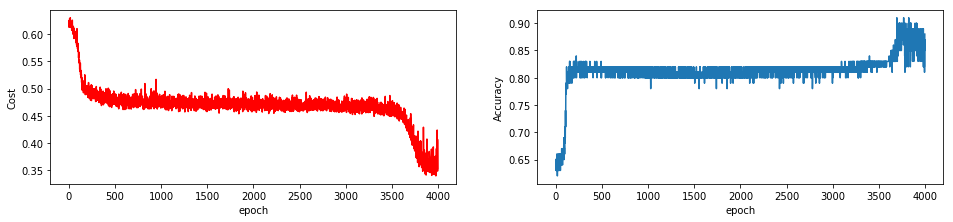

best_accuracy: 0.91 achieved at epoch: 3696


0.91

In [13]:
plot_cost_accuracy(sigmoid_costs, sigmoid_accuracies)

#### Visualize the posterior of the network trained above

In [14]:
def visualize_posterior(gt_posterior, network):
    #### RUN this after training is done
    x_rng = y_rng = np.linspace(0, 1, 50)
    gridx,gridy = np.meshgrid(x_rng, y_rng)

    grid_features = np.concatenate((gridx.reshape((-1,1)), gridy.reshape((-1,1))),axis=1)
    grid_tensor = torch.FloatTensor(grid_features)
    logits = network(Variable(grid_tensor))
    soft_max = torch.nn.Softmax()
    softmax_outputs = soft_max(logits)

    posterior_0 = softmax_outputs[:,0].data.numpy()
    posterior_1 = softmax_outputs[:,1].data.numpy()
    posterior_0 = posterior_0.reshape(50,50)
    posterior_1 = posterior_1.reshape(50,50)


    fig = plt.figure(figsize=plt.figaspect(0.2))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(posterior_1, extent=[0, 1, 0, 1], origin='lower')
    ax1.set_title(" Estimated $P(y=1 \mid x)$")
    ax1.set_xlabel("Feature 1")
    ax1.set_ylabel("Feature 2")

    ax1 = fig.add_subplot(1, 3, 2)
    ax1.imshow(gt_posterior, extent=[0, 1, 0, 1], origin='lower')
    ax1.set_title(" Ground Truth of the positive class $")
    ax1.set_xlabel("Feature 1")
    ax1.set_ylabel("Feature 2")

    ax1 = fig.add_subplot(1, 3, 3)
    ax1.imshow(posterior_1-gt_posterior, extent=[0, 1, 0, 1], origin='lower')
    ax1.set_title("Difference between the estimation and ground truth")
    ax1.set_xlabel("Feature 1")
    ax1.set_ylabel("Feature 2")
    plt.show()  
    

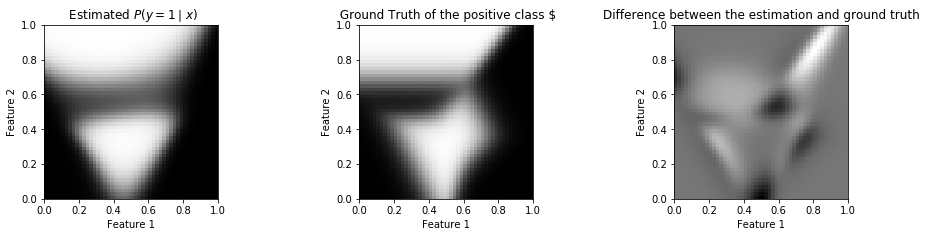

In [15]:
visualize_posterior(posterior,sigmoid_net)

<a id='question 2'></a>
## Train a network with ReLU non-linearities across all layers

In this assignment we'll create the same neural network as previously, but we'll use relu activations for the hidden layers instead. ( Hint: relu activations can be called as `F.relu()` in this notebook and as `torch.nn.functional.relu()` in general.
* Question 2: Add the necessary lines inside `__init__` and `forward`.


In [24]:
class ReluNet(nn.Module):
    def __init__(self):
        super().__init__()
        ###### TODO QUESTION 2 ########
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 2)
        ###### TODO QUESTION 2 ########
    
    def forward(self, x):
        ###### TODO QUESTION 2 ########

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        ###### TODO QUESTION 2 ########
        return x

   
    


In [20]:
#Next we'll create an instance of our ReluNet class
relu_net = ReluNet()

In [21]:
# Here we define the learning rate and the number of epochs for our training. 
learning_rate=0.05 # 
epochs = 1000  ## usually has already converged around that number

## Here we pick the cost function and the optimizer for our training
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(relu_net.parameters(), lr=learning_rate, momentum=0.9)

## Training ReluNet
In the next cell the actual training happens. The network is trained for many epochs and for each of the epochs we split our training data into mini batches using the DataLoader that we created previously and iteratively feed them into our network. After each iteration/optimizer step, the parameters are updated in such a way that the loss is minimized.

In [22]:
start = time.time()

relu_costs=[]  
relu_accuracies = []

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    num_of_batches = 0 
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
#         print(inputs.shape)
#         print(labels.shape)

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        logits = relu_net(inputs)
        loss = criterion(logits, labels.type(torch.LongTensor))
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        num_of_batches +=1
        
    # calculate test accuracy 
    test_logits = relu_net(Variable(test_features_tensor))
    _, test_predictions = torch.max(test_logits.data, 1)    
    correct_predictions = (test_predictions.int() == test_labels_tensor.int()).sum()
    test_length = test_labels_tensor.size()[0]
    accuracy = correct_predictions/test_length
    print('Epoch: %d/%d,  loss: %.3f, test accuracy: %.3f'%(epoch + 1,epochs, running_loss / num_of_batches, accuracy))
    relu_costs.append(running_loss/num_of_batches)
    relu_accuracies.append(accuracy)

    
end = time.time()
duration = end-start
print('Finished Training in %d seconds'%(end-start))

Epoch: 1/1000,  loss: 0.701, test accuracy: 0.490
Epoch: 2/1000,  loss: 0.697, test accuracy: 0.470
Epoch: 3/1000,  loss: 0.695, test accuracy: 0.510
Epoch: 4/1000,  loss: 0.690, test accuracy: 0.490
Epoch: 5/1000,  loss: 0.687, test accuracy: 0.550
Epoch: 6/1000,  loss: 0.685, test accuracy: 0.620
Epoch: 7/1000,  loss: 0.682, test accuracy: 0.520
Epoch: 8/1000,  loss: 0.671, test accuracy: 0.650
Epoch: 9/1000,  loss: 0.669, test accuracy: 0.640
Epoch: 10/1000,  loss: 0.661, test accuracy: 0.550
Epoch: 11/1000,  loss: 0.645, test accuracy: 0.660
Epoch: 12/1000,  loss: 0.640, test accuracy: 0.640
Epoch: 13/1000,  loss: 0.637, test accuracy: 0.660
Epoch: 14/1000,  loss: 0.625, test accuracy: 0.590
Epoch: 15/1000,  loss: 0.622, test accuracy: 0.650
Epoch: 16/1000,  loss: 0.622, test accuracy: 0.660
Epoch: 17/1000,  loss: 0.609, test accuracy: 0.650
Epoch: 18/1000,  loss: 0.612, test accuracy: 0.650
Epoch: 19/1000,  loss: 0.621, test accuracy: 0.680
Epoch: 20/1000,  loss: 0.603, test accur

Epoch: 161/1000,  loss: 0.395, test accuracy: 0.910
Epoch: 162/1000,  loss: 0.386, test accuracy: 0.810
Epoch: 163/1000,  loss: 0.390, test accuracy: 0.860
Epoch: 164/1000,  loss: 0.396, test accuracy: 0.870
Epoch: 165/1000,  loss: 0.395, test accuracy: 0.900
Epoch: 166/1000,  loss: 0.375, test accuracy: 0.860
Epoch: 167/1000,  loss: 0.366, test accuracy: 0.880
Epoch: 168/1000,  loss: 0.415, test accuracy: 0.860
Epoch: 169/1000,  loss: 0.355, test accuracy: 0.870
Epoch: 170/1000,  loss: 0.391, test accuracy: 0.890
Epoch: 171/1000,  loss: 0.386, test accuracy: 0.850
Epoch: 172/1000,  loss: 0.378, test accuracy: 0.880
Epoch: 173/1000,  loss: 0.350, test accuracy: 0.890
Epoch: 174/1000,  loss: 0.353, test accuracy: 0.880
Epoch: 175/1000,  loss: 0.364, test accuracy: 0.860
Epoch: 176/1000,  loss: 0.383, test accuracy: 0.890
Epoch: 177/1000,  loss: 0.387, test accuracy: 0.900
Epoch: 178/1000,  loss: 0.355, test accuracy: 0.890
Epoch: 179/1000,  loss: 0.411, test accuracy: 0.870
Epoch: 180/1

Epoch: 319/1000,  loss: 0.357, test accuracy: 0.900
Epoch: 320/1000,  loss: 0.357, test accuracy: 0.880
Epoch: 321/1000,  loss: 0.354, test accuracy: 0.850
Epoch: 322/1000,  loss: 0.368, test accuracy: 0.820
Epoch: 323/1000,  loss: 0.340, test accuracy: 0.860
Epoch: 324/1000,  loss: 0.372, test accuracy: 0.820
Epoch: 325/1000,  loss: 0.376, test accuracy: 0.910
Epoch: 326/1000,  loss: 0.347, test accuracy: 0.870
Epoch: 327/1000,  loss: 0.346, test accuracy: 0.880
Epoch: 328/1000,  loss: 0.359, test accuracy: 0.910
Epoch: 329/1000,  loss: 0.348, test accuracy: 0.840
Epoch: 330/1000,  loss: 0.353, test accuracy: 0.860
Epoch: 331/1000,  loss: 0.388, test accuracy: 0.880
Epoch: 332/1000,  loss: 0.378, test accuracy: 0.890
Epoch: 333/1000,  loss: 0.378, test accuracy: 0.820
Epoch: 334/1000,  loss: 0.366, test accuracy: 0.870
Epoch: 335/1000,  loss: 0.341, test accuracy: 0.870
Epoch: 336/1000,  loss: 0.363, test accuracy: 0.860
Epoch: 337/1000,  loss: 0.357, test accuracy: 0.900
Epoch: 338/1

Epoch: 477/1000,  loss: 0.342, test accuracy: 0.880
Epoch: 478/1000,  loss: 0.363, test accuracy: 0.860
Epoch: 479/1000,  loss: 0.354, test accuracy: 0.890
Epoch: 480/1000,  loss: 0.361, test accuracy: 0.850
Epoch: 481/1000,  loss: 0.347, test accuracy: 0.890
Epoch: 482/1000,  loss: 0.344, test accuracy: 0.870
Epoch: 483/1000,  loss: 0.352, test accuracy: 0.860
Epoch: 484/1000,  loss: 0.326, test accuracy: 0.870
Epoch: 485/1000,  loss: 0.347, test accuracy: 0.890
Epoch: 486/1000,  loss: 0.355, test accuracy: 0.880
Epoch: 487/1000,  loss: 0.367, test accuracy: 0.850
Epoch: 488/1000,  loss: 0.352, test accuracy: 0.870
Epoch: 489/1000,  loss: 0.383, test accuracy: 0.890
Epoch: 490/1000,  loss: 0.361, test accuracy: 0.820
Epoch: 491/1000,  loss: 0.374, test accuracy: 0.890
Epoch: 492/1000,  loss: 0.358, test accuracy: 0.890
Epoch: 493/1000,  loss: 0.381, test accuracy: 0.830
Epoch: 494/1000,  loss: 0.374, test accuracy: 0.890
Epoch: 495/1000,  loss: 0.363, test accuracy: 0.870
Epoch: 496/1

Epoch: 634/1000,  loss: 0.353, test accuracy: 0.860
Epoch: 635/1000,  loss: 0.335, test accuracy: 0.870
Epoch: 636/1000,  loss: 0.350, test accuracy: 0.860
Epoch: 637/1000,  loss: 0.340, test accuracy: 0.870
Epoch: 638/1000,  loss: 0.353, test accuracy: 0.890
Epoch: 639/1000,  loss: 0.336, test accuracy: 0.840
Epoch: 640/1000,  loss: 0.350, test accuracy: 0.880
Epoch: 641/1000,  loss: 0.362, test accuracy: 0.880
Epoch: 642/1000,  loss: 0.340, test accuracy: 0.840
Epoch: 643/1000,  loss: 0.340, test accuracy: 0.900
Epoch: 644/1000,  loss: 0.330, test accuracy: 0.860
Epoch: 645/1000,  loss: 0.338, test accuracy: 0.880
Epoch: 646/1000,  loss: 0.342, test accuracy: 0.840
Epoch: 647/1000,  loss: 0.374, test accuracy: 0.860
Epoch: 648/1000,  loss: 0.334, test accuracy: 0.850
Epoch: 649/1000,  loss: 0.329, test accuracy: 0.910
Epoch: 650/1000,  loss: 0.336, test accuracy: 0.860
Epoch: 651/1000,  loss: 0.334, test accuracy: 0.860
Epoch: 652/1000,  loss: 0.335, test accuracy: 0.860
Epoch: 653/1

Epoch: 791/1000,  loss: 0.352, test accuracy: 0.880
Epoch: 792/1000,  loss: 0.339, test accuracy: 0.890
Epoch: 793/1000,  loss: 0.340, test accuracy: 0.850
Epoch: 794/1000,  loss: 0.334, test accuracy: 0.860
Epoch: 795/1000,  loss: 0.325, test accuracy: 0.870
Epoch: 796/1000,  loss: 0.338, test accuracy: 0.860
Epoch: 797/1000,  loss: 0.330, test accuracy: 0.870
Epoch: 798/1000,  loss: 0.354, test accuracy: 0.880
Epoch: 799/1000,  loss: 0.345, test accuracy: 0.850
Epoch: 800/1000,  loss: 0.340, test accuracy: 0.880
Epoch: 801/1000,  loss: 0.330, test accuracy: 0.860
Epoch: 802/1000,  loss: 0.334, test accuracy: 0.850
Epoch: 803/1000,  loss: 0.335, test accuracy: 0.880
Epoch: 804/1000,  loss: 0.332, test accuracy: 0.860
Epoch: 805/1000,  loss: 0.342, test accuracy: 0.870
Epoch: 806/1000,  loss: 0.326, test accuracy: 0.850
Epoch: 807/1000,  loss: 0.343, test accuracy: 0.880
Epoch: 808/1000,  loss: 0.347, test accuracy: 0.870
Epoch: 809/1000,  loss: 0.360, test accuracy: 0.830
Epoch: 810/1

Epoch: 949/1000,  loss: 0.346, test accuracy: 0.870
Epoch: 950/1000,  loss: 0.341, test accuracy: 0.830
Epoch: 951/1000,  loss: 0.337, test accuracy: 0.880
Epoch: 952/1000,  loss: 0.353, test accuracy: 0.850
Epoch: 953/1000,  loss: 0.380, test accuracy: 0.870
Epoch: 954/1000,  loss: 0.339, test accuracy: 0.880
Epoch: 955/1000,  loss: 0.334, test accuracy: 0.860
Epoch: 956/1000,  loss: 0.364, test accuracy: 0.890
Epoch: 957/1000,  loss: 0.353, test accuracy: 0.870
Epoch: 958/1000,  loss: 0.352, test accuracy: 0.870
Epoch: 959/1000,  loss: 0.363, test accuracy: 0.860
Epoch: 960/1000,  loss: 0.321, test accuracy: 0.860
Epoch: 961/1000,  loss: 0.341, test accuracy: 0.850
Epoch: 962/1000,  loss: 0.333, test accuracy: 0.850
Epoch: 963/1000,  loss: 0.341, test accuracy: 0.860
Epoch: 964/1000,  loss: 0.334, test accuracy: 0.880
Epoch: 965/1000,  loss: 0.343, test accuracy: 0.850
Epoch: 966/1000,  loss: 0.319, test accuracy: 0.870
Epoch: 967/1000,  loss: 0.347, test accuracy: 0.870
Epoch: 968/1

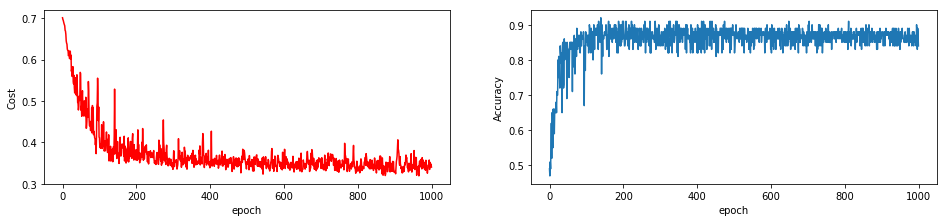

best_accuracy: 0.92 achieved at epoch: 139


0.92

In [23]:
plot_cost_accuracy(relu_costs, relu_accuracies)

#### Visualize the posterior of the network trained above

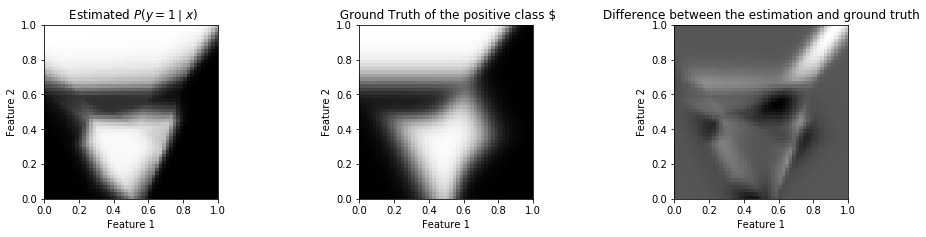

In [25]:
visualize_posterior(posterior,relu_net)

<a id='question 3'></a>
# Cross Validation to pick number of nodes for the hidden layers and the weight decay parameter $\lambda$

In this part we are going to use cross validation to try and find the best values for the number of nodes of the hidden layers as well as for the weight decay. We'll use again relu activations.
* <b>Question 3:</b> Add the necessary lines inside `__init__` and `forward` in order to define a network that can have a variable number of nodes N. The number of nodes for each layer will be [2, N, N, 2]. Notice that this time the constructor function `__init()__` has a extra argument N, that will allow us to specify the number of nodes when creating an object of this class.

In [26]:
class ReluNetVariableNodes(nn.Module):
    def __init__(self,N):
        super().__init__()
        ###### TODO QUESTION 3 ########
        self.N = N
        self.fc1 = nn.Linear(2,self.N)
        self.fc2 = nn.Linear(self.N,self.N)
        self.fc3 = nn.Linear(self.N,2)      
        ###### TODO QUESTION 3 ########
   
    def forward(self, x):
        ###### TODO QUESTION 3 ########
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)


        ###### TODO QUESTION 3 ########
        return x
    

The following cell is only conveniently wrapping the whole training procedure inside a function in order to better organize our code. The function returns the best accuracy achieved.

In [27]:
def train_network(training_features, training_labels, test_features, test_labels, lamda, num_of_nodes, epochs = 1000, learning_rate =0.01):   
    start = time.time()
    net = ReluNetVariableNodes(num_of_nodes)
    
    training_features_tensor = torch.FloatTensor(training_features)
    training_labels_tensor = torch.FloatTensor(training_labels)
    testing_features_tensor = torch.FloatTensor(test_features)
    testing_labels_tensor = torch.FloatTensor(test_labels)
    
    trainset = torch.utils.data.TensorDataset(training_features_tensor, training_labels_tensor)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=40, shuffle=True, num_workers=2)
    
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, weight_decay=lamda, momentum=0.9)
    
    costs = []
    accuracies = []
    
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        num_of_batches = 0 
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            logits = net(inputs)
            loss = criterion(logits, labels.type(torch.LongTensor))

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data[0]
            num_of_batches +=1

        # calculate test accuracy 
        test_logits = net(Variable(testing_features_tensor))
        _, test_predictions = torch.max(test_logits.data, 1)    
        correct_predictions = (test_predictions.int() == testing_labels_tensor.int()).sum()
        test_length = testing_labels_tensor.size()[0]
        accuracy = correct_predictions/test_length
        if epoch%(epochs//10) == 0:
            print('Epoch: %d/%d,  loss: %.3f, test accuracy: %.3f'%(epoch + 1,epochs, running_loss / num_of_batches, accuracy))
        costs.append(running_loss/num_of_batches)
        accuracies.append(accuracy)
    
    end = time.time()
    duration = end-start
    print('Finished Training in %d seconds'%(end-start))
    best_accuracy = plot_cost_accuracy(costs, accuracies)
    
    return best_accuracy, net

In [28]:
def logsample(start, end, num):
    return np.logspace(np.log10(start), np.log10(end), num, base=10.0)

num_of_lamdas = 3
lamda_range = logsample(1e-5, 1e-2, num_of_lamdas)
#lamda_range = [0.0001, 0.001, 0.01, 0.1, 1]
nodes_range = [5, 10, 20]

<a id='question 4'></a>
### Compute the cross-validation accuracy for each parameter combination

Now we are going to again use cross-validation (see assignment 3) in order to find the optimal hyperparameters for our network. However instead of splitting our training set into K-Folds, we'll create a single training/validation split which we'll use for our hyperparameter grid search and therefore the *KFold* class from scikit-learn that we used in assignment 3 won't be necessary here.

Be warned that this part might take about 10 minutes to run. Try it out for less epochs (maybe 100) to check if everything is working and only then run it for more epochs to improve your results. 

* <b>Question 4:</b> Fill in the necessary lines in the double loop iterating over the weight decay and number of nodes (parameter grid-search) in order to perform cross-validation. For each combination of hyperparameters, retrain the network calling the function `train_network()` with the right arguments.


CROSS VALIDATION for num_of_nodes = 5 and lamda = 0.000010 
Epoch: 1/1000,  loss: 0.731, test accuracy: 0.583
Epoch: 101/1000,  loss: 0.691, test accuracy: 0.417
Epoch: 201/1000,  loss: 0.634, test accuracy: 0.667
Epoch: 301/1000,  loss: 0.527, test accuracy: 0.783
Epoch: 401/1000,  loss: 0.490, test accuracy: 0.817
Epoch: 501/1000,  loss: 0.487, test accuracy: 0.817
Epoch: 601/1000,  loss: 0.499, test accuracy: 0.800
Epoch: 701/1000,  loss: 0.490, test accuracy: 0.817
Epoch: 801/1000,  loss: 0.489, test accuracy: 0.817
Epoch: 901/1000,  loss: 0.489, test accuracy: 0.817
Finished Training in 36 seconds


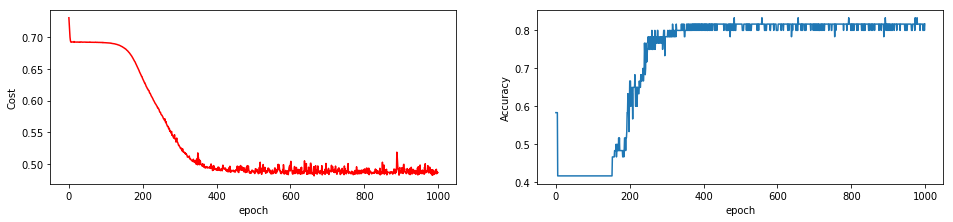

best_accuracy: 0.8333333333333334 achieved at epoch: 483

CROSS VALIDATION for num_of_nodes = 5 and lamda = 0.000316 
Epoch: 1/1000,  loss: 0.772, test accuracy: 0.417
Epoch: 101/1000,  loss: 0.649, test accuracy: 0.533
Epoch: 201/1000,  loss: 0.569, test accuracy: 0.750
Epoch: 301/1000,  loss: 0.505, test accuracy: 0.783
Epoch: 401/1000,  loss: 0.495, test accuracy: 0.817
Epoch: 501/1000,  loss: 0.491, test accuracy: 0.817
Epoch: 601/1000,  loss: 0.485, test accuracy: 0.817
Epoch: 701/1000,  loss: 0.495, test accuracy: 0.800
Epoch: 801/1000,  loss: 0.492, test accuracy: 0.817
Epoch: 901/1000,  loss: 0.486, test accuracy: 0.833
Finished Training in 38 seconds


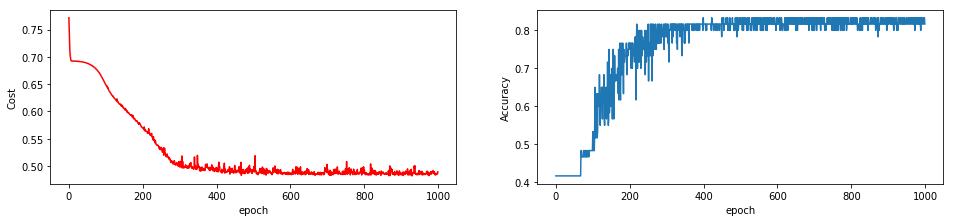

best_accuracy: 0.8333333333333334 achieved at epoch: 399

CROSS VALIDATION for num_of_nodes = 5 and lamda = 0.010000 
Epoch: 1/1000,  loss: 0.700, test accuracy: 0.500
Epoch: 101/1000,  loss: 0.639, test accuracy: 0.467
Epoch: 201/1000,  loss: 0.640, test accuracy: 0.483
Epoch: 301/1000,  loss: 0.639, test accuracy: 0.483
Epoch: 401/1000,  loss: 0.639, test accuracy: 0.483
Epoch: 501/1000,  loss: 0.640, test accuracy: 0.517
Epoch: 601/1000,  loss: 0.639, test accuracy: 0.500
Epoch: 701/1000,  loss: 0.639, test accuracy: 0.483
Epoch: 801/1000,  loss: 0.639, test accuracy: 0.483
Epoch: 901/1000,  loss: 0.638, test accuracy: 0.500
Finished Training in 39 seconds


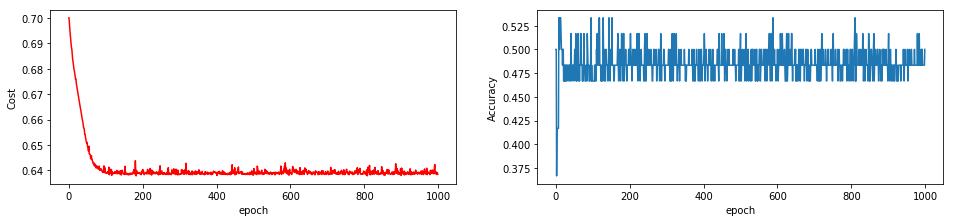

best_accuracy: 0.5333333333333333 achieved at epoch: 8

CROSS VALIDATION for num_of_nodes = 10 and lamda = 0.000010 
Epoch: 1/1000,  loss: 0.697, test accuracy: 0.583
Epoch: 101/1000,  loss: 0.604, test accuracy: 0.650
Epoch: 201/1000,  loss: 0.513, test accuracy: 0.800
Epoch: 301/1000,  loss: 0.466, test accuracy: 0.833
Epoch: 401/1000,  loss: 0.397, test accuracy: 0.850
Epoch: 501/1000,  loss: 0.371, test accuracy: 0.867
Epoch: 601/1000,  loss: 0.369, test accuracy: 0.883
Epoch: 701/1000,  loss: 0.357, test accuracy: 0.867
Epoch: 801/1000,  loss: 0.356, test accuracy: 0.883
Epoch: 901/1000,  loss: 0.359, test accuracy: 0.883
Finished Training in 36 seconds


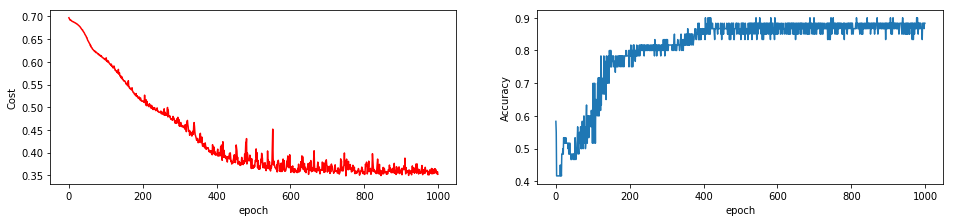

best_accuracy: 0.9 achieved at epoch: 405

CROSS VALIDATION for num_of_nodes = 10 and lamda = 0.000316 
Epoch: 1/1000,  loss: 0.720, test accuracy: 0.583
Epoch: 101/1000,  loss: 0.646, test accuracy: 0.517
Epoch: 201/1000,  loss: 0.589, test accuracy: 0.733
Epoch: 301/1000,  loss: 0.520, test accuracy: 0.800
Epoch: 401/1000,  loss: 0.523, test accuracy: 0.733
Epoch: 501/1000,  loss: 0.505, test accuracy: 0.817
Epoch: 601/1000,  loss: 0.508, test accuracy: 0.783
Epoch: 701/1000,  loss: 0.503, test accuracy: 0.800
Epoch: 801/1000,  loss: 0.490, test accuracy: 0.817
Epoch: 901/1000,  loss: 0.484, test accuracy: 0.800
Finished Training in 30 seconds


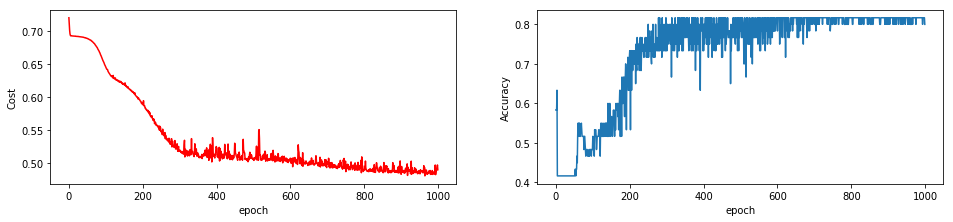

best_accuracy: 0.8166666666666667 achieved at epoch: 278

CROSS VALIDATION for num_of_nodes = 10 and lamda = 0.010000 
Epoch: 1/1000,  loss: 0.717, test accuracy: 0.583
Epoch: 101/1000,  loss: 0.615, test accuracy: 0.517
Epoch: 201/1000,  loss: 0.560, test accuracy: 0.783
Epoch: 301/1000,  loss: 0.525, test accuracy: 0.783
Epoch: 401/1000,  loss: 0.521, test accuracy: 0.783
Epoch: 501/1000,  loss: 0.520, test accuracy: 0.783
Epoch: 601/1000,  loss: 0.519, test accuracy: 0.783
Epoch: 701/1000,  loss: 0.522, test accuracy: 0.783
Epoch: 801/1000,  loss: 0.521, test accuracy: 0.783
Epoch: 901/1000,  loss: 0.517, test accuracy: 0.783
Finished Training in 33 seconds


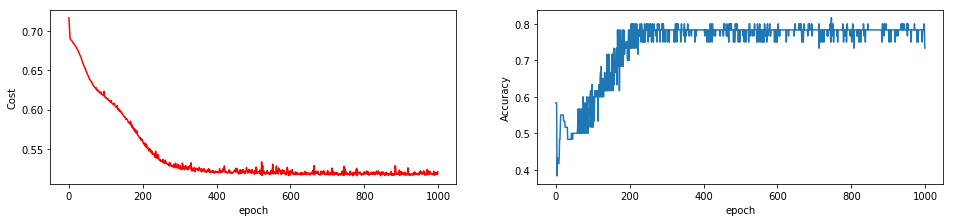

best_accuracy: 0.8166666666666667 achieved at epoch: 746

CROSS VALIDATION for num_of_nodes = 20 and lamda = 0.000010 
Epoch: 1/1000,  loss: 0.704, test accuracy: 0.417
Epoch: 101/1000,  loss: 0.622, test accuracy: 0.517
Epoch: 201/1000,  loss: 0.534, test accuracy: 0.783
Epoch: 301/1000,  loss: 0.484, test accuracy: 0.817
Epoch: 401/1000,  loss: 0.409, test accuracy: 0.833
Epoch: 501/1000,  loss: 0.385, test accuracy: 0.883
Epoch: 601/1000,  loss: 0.379, test accuracy: 0.883
Epoch: 701/1000,  loss: 0.390, test accuracy: 0.867
Epoch: 801/1000,  loss: 0.374, test accuracy: 0.883
Epoch: 901/1000,  loss: 0.379, test accuracy: 0.850
Finished Training in 33 seconds


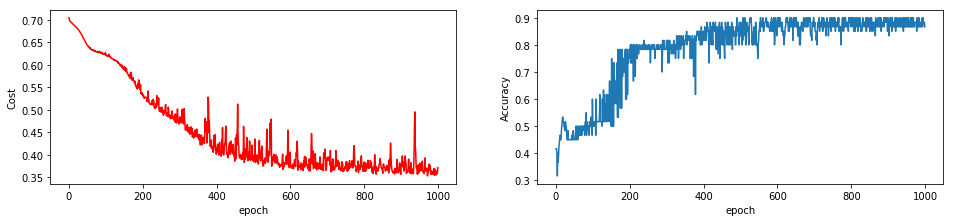

best_accuracy: 0.9 achieved at epoch: 490

CROSS VALIDATION for num_of_nodes = 20 and lamda = 0.000316 
Epoch: 1/1000,  loss: 0.700, test accuracy: 0.583
Epoch: 101/1000,  loss: 0.566, test accuracy: 0.750
Epoch: 201/1000,  loss: 0.488, test accuracy: 0.783
Epoch: 301/1000,  loss: 0.451, test accuracy: 0.817
Epoch: 401/1000,  loss: 0.383, test accuracy: 0.883
Epoch: 501/1000,  loss: 0.354, test accuracy: 0.900
Epoch: 601/1000,  loss: 0.367, test accuracy: 0.900
Epoch: 701/1000,  loss: 0.356, test accuracy: 0.883
Epoch: 801/1000,  loss: 0.356, test accuracy: 0.900
Epoch: 901/1000,  loss: 0.361, test accuracy: 0.883
Finished Training in 28 seconds


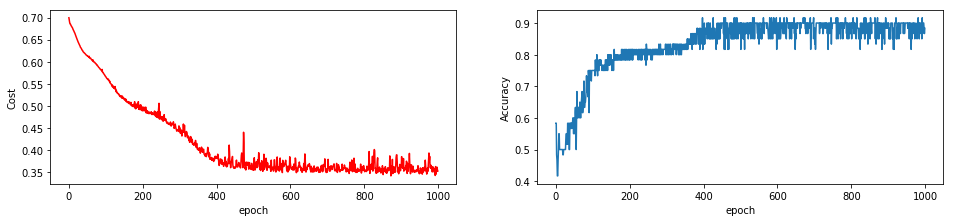

best_accuracy: 0.9166666666666666 achieved at epoch: 397

CROSS VALIDATION for num_of_nodes = 20 and lamda = 0.010000 
Epoch: 1/1000,  loss: 0.693, test accuracy: 0.417
Epoch: 101/1000,  loss: 0.636, test accuracy: 0.533
Epoch: 201/1000,  loss: 0.630, test accuracy: 0.500
Epoch: 301/1000,  loss: 0.619, test accuracy: 0.550
Epoch: 401/1000,  loss: 0.588, test accuracy: 0.650
Epoch: 501/1000,  loss: 0.551, test accuracy: 0.767
Epoch: 601/1000,  loss: 0.529, test accuracy: 0.767
Epoch: 701/1000,  loss: 0.524, test accuracy: 0.783
Epoch: 801/1000,  loss: 0.514, test accuracy: 0.800
Epoch: 901/1000,  loss: 0.506, test accuracy: 0.800
Finished Training in 39 seconds


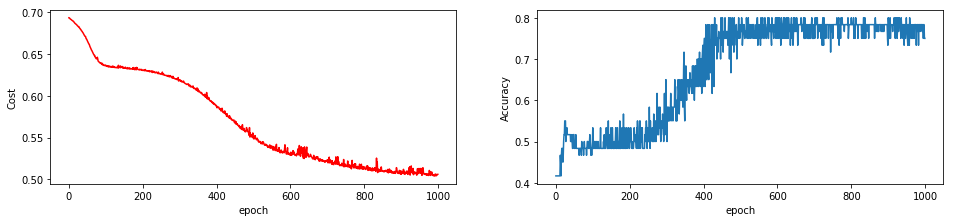

best_accuracy: 0.8 achieved at epoch: 430
Finished Grid Search in 318 seconds


In [29]:
cv_start = time.time()

split_percentage = 0.2
length_training = len(training_labels)
validation_split = np.int(np.ceil(split_percentage*length_training))
random_indices = np.random.permutation(np.arange(length_training))
cv_training_set_features = training_features[random_indices[validation_split:]]
cv_training_set_targets = training_labels[random_indices[validation_split:]]
cv_validation_set_features = training_features[random_indices[:validation_split]]
cv_validation_set_targets = training_labels[random_indices[:validation_split]]
cv_accuracy = np.zeros((len(nodes_range), num_of_lamdas))  # error matrix

learning_rate = 0.05
epochs = 1000

###### TODO QUESTION 4 ########

for i,num_of_nodes in enumerate(nodes_range,0) :
    for j,lamda in enumerate(lamda_range,0):
## loop hyperparameter num_of_nodes
##    loop hyperparameter lamda (i.e. weight decay)

        print('\nCROSS VALIDATION for num_of_nodes = %d and lamda = %f '%(num_of_nodes, lamda))        
        
        ## add the right arguments for function train_network
        best_accuracy,_ = train_network(cv_training_set_features,cv_training_set_targets,cv_validation_set_features,cv_validation_set_targets,lamda,num_of_nodes ) 
        # Save the best cv_accuracy for the current combination of parameters 
        cv_accuracy[i, j] = best_accuracy
###### TODO QUESTION 4 ########
cv_end = time.time()
print('Finished Grid Search in %d seconds'%(cv_end-cv_start))

([<matplotlib.axis.XTick at 0x11590ff60>,
 <a list of 3 Text xticklabel objects>)

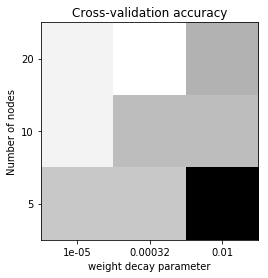

In [30]:
# Display accuracies
fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 1, 1)
ax.set_title("Cross-validation accuracy")
ax.set_xlabel("weight decay parameter")
ax.set_ylabel("Number of nodes")
#plt.xticks
plt.imshow(cv_accuracy, cmap='gray', origin='lower')
plt.yticks(range(len(nodes_range)),nodes_range)
plt.xticks(range(len(lamda_range)),np.round(lamda_range,5))


In [31]:
# Find weight decay  and number of nodes giving the highest accuracy
max_ind = cv_accuracy.argmax()  # index of the max in the flattened array
node_ind, lamda_ind = np.unravel_index(max_ind, cv_accuracy.shape)  # matrix indices
best_lamda = lamda_range[lamda_ind]
best_node_num = nodes_range[node_ind]

print( 'Highest accuracy give by lamda = %f and num_of_nodes=%d'%(best_lamda, best_node_num))

Highest accuracy give by lamda = 0.000316 and num_of_nodes=20


## Finally train a network on the full training set using the best combination of parameters 

Epoch: 1/1000,  loss: 0.693, test accuracy: 0.500
Epoch: 101/1000,  loss: 0.383, test accuracy: 0.850
Epoch: 201/1000,  loss: 0.396, test accuracy: 0.910
Epoch: 301/1000,  loss: 0.380, test accuracy: 0.900
Epoch: 401/1000,  loss: 0.357, test accuracy: 0.860
Epoch: 501/1000,  loss: 0.365, test accuracy: 0.870
Epoch: 601/1000,  loss: 0.374, test accuracy: 0.850
Epoch: 701/1000,  loss: 0.347, test accuracy: 0.870
Epoch: 801/1000,  loss: 0.325, test accuracy: 0.870
Epoch: 901/1000,  loss: 0.361, test accuracy: 0.880
Finished Training in 35 seconds


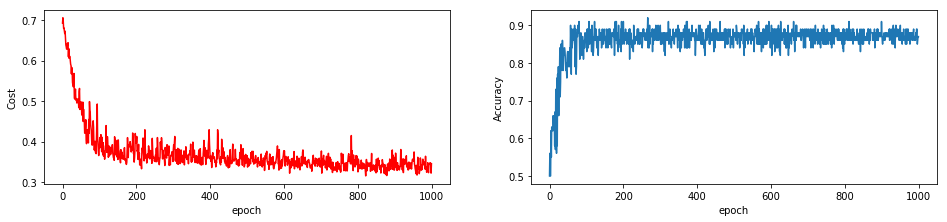

best_accuracy: 0.92 achieved at epoch: 266


In [32]:
best_accuracy, final_net = train_network(training_features, training_labels, 
                                             test_features, test_labels, 
                                             best_lamda, best_node_num, learning_rate = learning_rate, epochs = epochs) 